In [ ]:
import cv2
import glob
import numpy as np 
import pandas as pd 

import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from radam import RAdam
from torch.optim import Adam
import torch.nn.functional as F

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

import imgaug as ia
import imgaug.augmenters as iaa
import copy
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



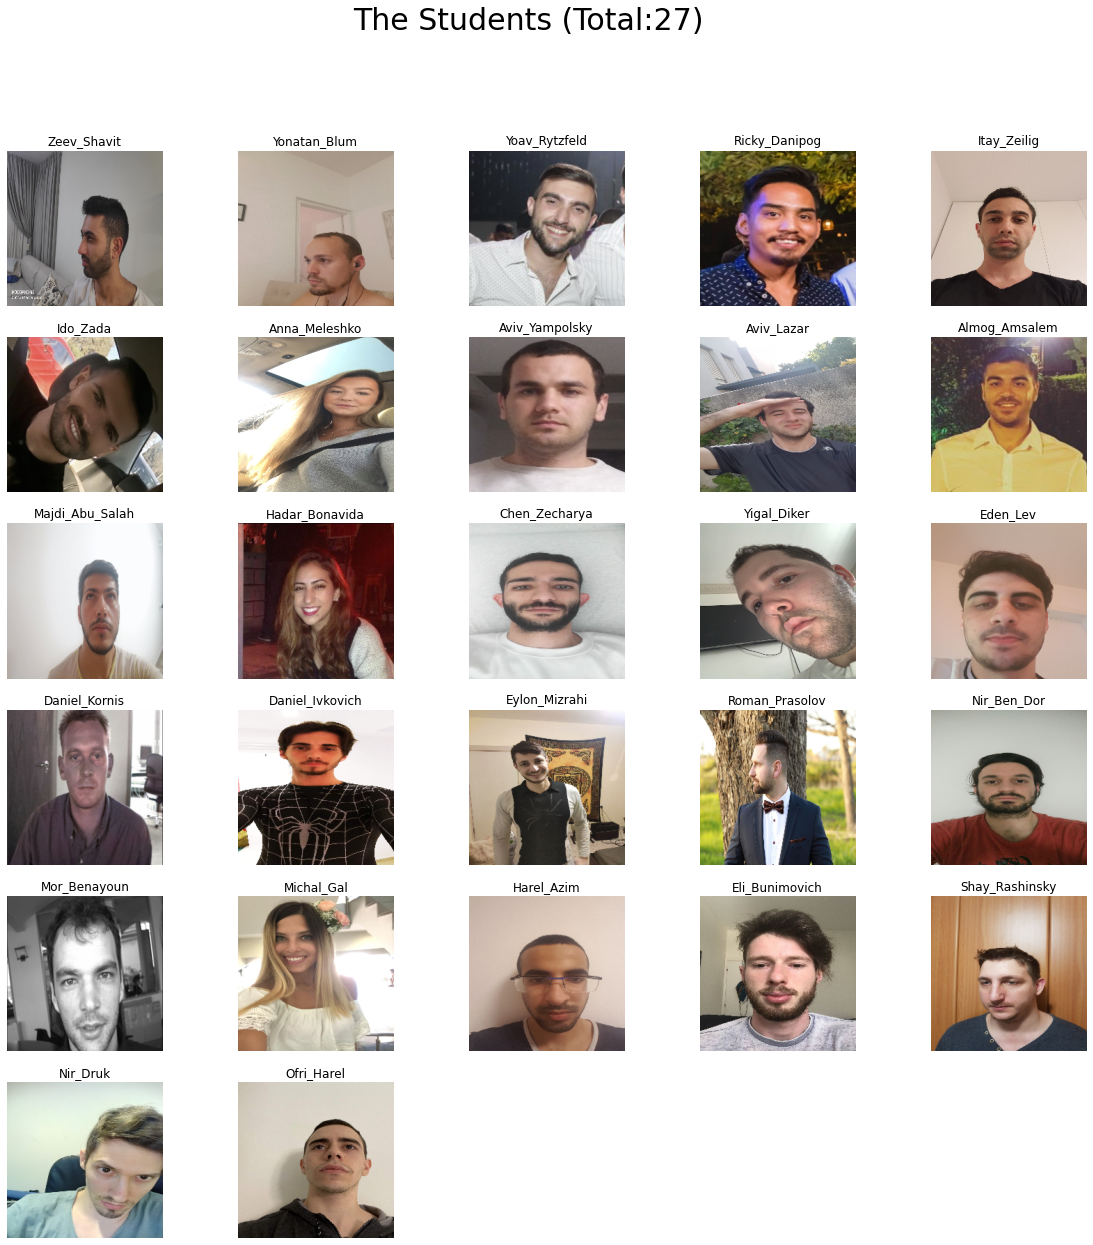

In [65]:
def get_classes(datapath, plot=True):
    row = 6
    col = 5
    names = []

    if plot:
        plt.figure(figsize=[20,20])

    for x in datapath:
        name = x.split('/')[-2]
        if name in names:
            continue
        if plot:
            plt.subplot(row,col,len(names)+1)
            
            img = cv2.imread(x)
            img = cv2.resize(img,(224,224),cv2.INTER_AREA)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

            plt.imshow(img)
            plt.axis('off')
            plt.title(name)
        names.append(name)
    if plot:
        plt.suptitle(f'The Students (Total:{len(names)})',fontsize=30)
        plt.show()
    return names
    
        
data_path = glob.glob('/content/drive/My Drive/Colab Notebooks/CV/ImagesCV/*/*.*[!txt]')
classes = get_classes(data_path,plot=True)

# FACE DETECTION 

I used the face detection classifier to detect and crop faces when loading an image by cropping the face from the image.the reason is that many images are not uniform. 

e.g some images included all of the body when some images included on the face which make the dataset unbalanced, so i wanted to make it more uniform by cropping the dace ROI from the image.

The result were better(accuracy and loss). 

The model that i used Caffe deep learning model provided by opencv. the classifier detects faces tha output of this classifer is list of the face ROI
and confindence. Confidence is variable of how much the model is confidnt that is a face. So, by extracting the ROI with the biggest confindence I was sure enough that is the face of the student.

more on the subject [here](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/)

There Are some Samples that are not good for my purpose so i decided to leave them out


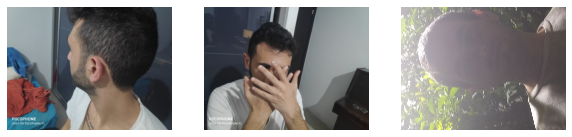

In [6]:
# Clean Data : images that cannot be classified
remove_lst = ['/content/drive/My Drive/Colab Notebooks/CV/ImagesCV/Zeev_Shavit/zeev 22.jpeg',
        '/content/drive/My Drive/Colab Notebooks/CV/ImagesCV/Zeev_Shavit/zeev 19.jpeg',
        '/content/drive/My Drive/Colab Notebooks/CV/ImagesCV/Aviv_Yampolsky/IMG_20200518_211458.jpg']
plt.figure(figsize=[10,10])
for index,path in enumerate(remove_lst):
    plt.subplot(1,len(remove_lst),index+1)
    img = plt.imread(path)
    plt.imshow(img)
    plt.axis('off')
    data_path.remove(path)
plt.show()



---


In [0]:
class FaceDetector:

    '''The face detection class'''

    def __init__(self):
        self.face_detector = cv2.dnn.readNetFromCaffe('/content/deploy.prototxt.txt', '/content/res10_300x300_ssd_iter_140000.caffemodel')

    def get_face_ROI(self, image):
        size = image.shape[0]
        blob = cv2.dnn.blobFromImage(image, 1.0,(size, size))
        self.face_detector.setInput(blob)
        detections = self.face_detector.forward()
        if len(detections) > 0:
            i = np.argmax(detections[0, 0, :, 2])
            confidence = detections[0, 0, i, 2]
            if confidence > 0.1:
                box = (detections[0, 0, i, 3:7]  * size).astype(int)
                box[box<0] = 0
                return box.astype(int)
        return []
   

class FaceDataset(Dataset):
    # some images were needed to be rotated 
    img_to_rot = ['/content/drive/My Drive/Colab Notebooks/CV/ImagesCV/Yoav_Rytzfeld/18.jpg'] 

    def __init__(self, data, classes, size=224, transform=None, preprocess=None,face_detector=FaceDetector(), test_mode=False):
        super(FaceDataset,self).__init__()
        self.data = data
        if type(classes) == list:
            classes = np.array(classes)
        self.classes = classes
        self.size = size
        self.preprocess = preprocess
        self.transform = transform
        self.face_detector = face_detector
        self.test_mode = test_mode

    def crop_face(self, image):
        detection = self.face_detector.get_face_ROI(image)
        face = np.zeros_like(image)
        if len(detection) > 0:
                (startX, startY, endX, endY) = detection
                face = image[startY:endY, startX:endX]
                face = cv2.resize(face, (self.size,self.size),cv2.INTER_AREA)
        return face

    def __getitem__(self, idx):
        image = cv2.imread(self.data[idx], cv2.IMREAD_COLOR)
        label = self.data[idx].split('/')[-2]
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        if self.data[idx] in self.img_to_rot:
            image = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    
        image = cv2.resize(image,(self.size,self.size),cv2.INTER_AREA)
        image = self.crop_face(image)

        if self.preprocess != None:
            image = self.preprocess(image)  
            
        if self.transform != None :
            image = tv.transforms.ToPILImage()(image)
            image = self.transform(image)

        label = np.where(self.classes== label)[0][0]
        if not self.test_mode:
            return image, label
        else:
            return image, label, self.data[idx]
    
    def __len__(self):
        return len(self.data)


def normalize(img):
    img -=img.min()
    img/=img.max()
    return img

# Augmentations
More information on the augmentations I used can be found on the last assignment or on imageaug documentations.

In [0]:
transfroms =  tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])

seq = iaa.Sequential(
    [  
        iaa.SomeOf((0, 5),
            [
                iaa.Rotate((-20, 20),mode=ia.ALL),
                iaa.Fliplr(0.5),
                iaa.OneOf([
                    iaa.GaussianBlur(),iaa.AverageBlur(k=(1, 3)),iaa.MedianBlur(k=(1, 3)),
                ]),
                iaa.OneOf([
                    iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5)), 
                    iaa.Emboss(alpha=(0, 0.3), strength=(0, 2.0))
                    ]),
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.BlendAlphaFrequencyNoise(
                        exponent=(-4, 0),
                        foreground=iaa.Multiply((0.5, 1.5), per_channel=True),
                        background=iaa.LinearContrast((0.5, 2.0))
                    ),
                    iaa.Add((-10, 10), per_channel=0.5), 
                    iaa.AddToHueAndSaturation((-20, 20)), 
                    iaa.LinearContrast((0.5, 2.0), per_channel=0.5), 
                    iaa.Grayscale(alpha=(0.0, 1.0)),
                ]), 
            ],
            random_order=True
        )
    ],
    random_order=True
)

# Data Loaders:
* Train
* Valdiation
* Test

On this assignment I chose The above augmentations, some augmentations were removed from the last assignment, due to limits of processing and bad augmentations that ruined the images.

The test_mode Variable decides if to return the orginal image path for for displaying some test examples.


In [ ]:
SEED=4492
face_detector = FaceDetector()
batch_size = 16
X_train, X_test = train_test_split(data_path,  test_size=0.2,random_state=SEED)
X_train, X_val = train_test_split(X_train,  test_size=0.1, random_state=SEED)

train_data = FaceDataset(X_train, classes, transform=transfroms, face_detector=face_detector, preprocess=seq.augment_image)
train_loader =  DataLoader(train_data, batch_size, shuffle=True, num_workers=4)

val_data = FaceDataset(X_val, classes, transform=transfroms, face_detector=face_detector)
val_loader =  DataLoader(val_data, batch_size,shuffle=True, num_workers=4)

test_data = FaceDataset(X_test, classes, transform=transfroms, face_detector=face_detector, test_mode=True)
test_loader =  DataLoader(test_data, batch_size, shuffle=True, num_workers=4)


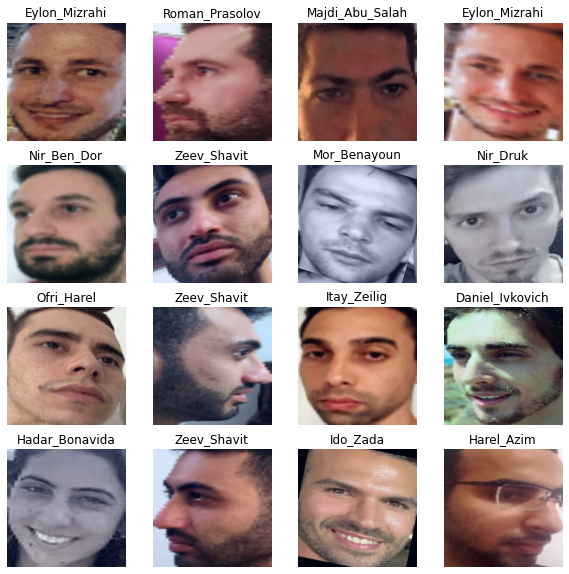

In [11]:
batch = iter(train_loader)
img,label = next(batch)
img = img.numpy()

plt.figure(figsize=[10, 10])
for i, (row, t) in enumerate(zip(img, label)):
    plt.subplot(4, 4, i+1)

    if row.shape[0] == 3:
        im = row.transpose(1, 2, 0)
    else:
        im = row.reshape((row.shape[1],row.shape[2])) 

    plt.imshow(normalize(im))
    plt.axis('off')
    plt.title(train_data.classes[t])
plt.show()


---

# Satistics UTILS

I used **sklearn** library to for the satistics sklearn provide variety of methods that give us a lot of information on the trainig phase and the test phase.

The methods i used are confusion_matrix, classification_report,
those methods are great for easy scoring and evaluations.


---


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import namedtuple
import seaborn as sn

Sample = namedtuple('Sample',['image','prediction','actual','p'])
 
def plot_graphs(train,val,title,y_label=''):
    '''
        ploting graphs with the given points

        @train - train checkpoints
        @val - val checkpoints
    '''
    plt.plot(train,'b')
    plt.plot(val,'g')
    plt.xlabel('Iterations')
    plt.ylabel(y_label)
    plt.legend(['Train','Validation'])
    plt.title(title)
    plt.grid(b=True, which='major', color='#666666', linestyle='-')


def plot_val_vs_train(train_losses, val_losses,train_acc, val_acc, model_name=''):
    plt.figure(figsize=[12,5])

    plt.subplot(1,2,1) 
    plot_graphs(train_losses, val_losses, title= f'{model_name} Loss', y_label='Loss')

    plt.subplot(1,2,2) 
    plot_graphs(train_acc, val_acc, title=f'{model_name} Accuracy' , y_label='Accuracy')
    
    plt.show()


def get_predictions(model, loader):
    '''
        Given a FaceDataset dataloader(with test_mode=True) this methods compute the predictions 
        and save the prediction and the samples path.
    '''
    y_preds = np.array([],np.uint8)
    y_actual = np.array([],np.uint8)
    tp,fp = [],[]
    with torch.no_grad():
        for data in loader:
            images, labels, paths = data[0].to(device),data[1].to(device),data[2]
            outputs = F.softmax(model(images),dim=1)
            prob, predicted = torch.max(outputs.data, 1)

            y_preds = np.append(y_preds,predicted.cpu().detach().numpy())
            y_actual = np.append(y_actual,labels.cpu().detach().numpy())

            for x in list(np.where(predicted.cpu() == labels.cpu())[0]):
                s = Sample(image=paths[x],prediction=predicted[x].item(),actual=labels[x].item(),p=prob[x].item())
                tp.append(s)
        
            for x in list(np.where(predicted.cpu() != labels.cpu())[0]):
                s = Sample(image=paths[x],prediction=predicted[x].item(),actual=labels[x].item(),p=prob[x].item())
                fp.append(s)
    
    return y_preds, y_actual, {'True Positives' : tp, 'False Positives': fp}

def show_examples(samples, amount): 
    
    for key in samples.keys():
        count = 0
        
        if len(samples[key]) == 0:
            print(f'No Samples of {key}')
            continue
        plt.figure(figsize=[15,5])
        plt.suptitle(key + ' Examples',fontsize=22)

        for x in range(amount):
            plt.subplot(1,amount,count+1)
            actual_index = samples[key][x].actual
            predict_index = samples[key][x].prediction
            img = cv2.imread(samples[key][x].image)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224),cv2.INTER_AREA)
            text = "Predicted:{:.2f}%".format(samples[key][x].p * 100)
            (startX, startY,endX, endY) = face_detector.get_face_ROI(img)
            cv2.rectangle(img, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(img, text, (startX+10, startY+10),cv2.FONT_ITALIC, 0.4, (0, 255, 255), 1)
            
        
            plt.title(classes[predict_index])
            plt.xlabel(f'Actual:{classes[actual_index]}')
            plt.imshow(img)
            count+=1
        plt.show()

def show_scores(y_actual, y_preds):
    cm = confusion_matrix(y_actual, y_preds, labels=range(len(classes)))
    df_cm = pd.DataFrame(cm, range(len(classes)), range(len(classes)))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap='Blues')
    plt.show()
    print(classification_report(y_actual, y_preds, target_names=classes))


# Training Models:

Trainig VGG16 from scratch, and training pretrained models to classify the students.

I tested a few variants of  loss functions, optimizers, parameters

## Loss Functions:
* CrossEntropy
* FocalLoss

## Optimizers:
* Adam
* RAdam

## Parameters:
* LR : [1e-2, 1e-3, 1e-4]
* weight_decay: [1e-4, 1e-5]*
* dropouts: [0-0.7]* 

On some models i noticed that the model performs well on the validation and badly on the training so i tried lower regulariztion params. The results were better, as the loss went down and the accuracy gotten better.


The learning rate was tuned using schdulers and by observing the loss during the train. e.g. If the loss were gotten smaller but on small pace I immidiatly raised the learning rate.


On most models I used the CrossEntropy After diving into those subjects i Learned that Focalloss doesn't fit good for my problem but I still used it to compare losses and results.
Most of the runs CE loss got me better results.

---


In [0]:
def fit_model(model, criterion, optimizer, scheduler, epochs=20):


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses,train_accs, val_accs = [], [], [], []
    try:
        model.to(device)
        criterion.to(device)

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            train_acc = 0
            running_loss = 0
            total = 0
            correct = 0
            for data in tqdm(train_loader, desc=f'[Epoch {epoch+1}/{epochs}]'):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                loss.backward()

                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / total
            train_acc = correct / total
        
            running_loss = 0
            total = 0
            correct = 0
            model.eval()

            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = val_data[0].to(device),val_data[1].to(device)
                    val_outputs = model(val_inputs)

                    loss = criterion(val_outputs, val_labels)
                    running_loss += loss.item() * val_inputs.size(0)

                    #count prediction hits
                    _, predicted = torch.max(val_outputs, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()

            val_loss = running_loss / total
            val_acc = correct / total
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)  
            train_accs.append(train_acc)  
            val_accs.append(val_acc)  
            
            print(f"Epoch {epoch+1}/{epochs}\t"
                f"Train loss: {train_loss:.5f}\t"
                f"Train accuracy: {(train_acc)*100:.3f}\t"
                f"Validation loss: {val_loss:.5f} \t "
                f"Validation accuracy: {(val_acc)*100:.3f}")

            if val_acc >= best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            scheduler.step()

        model.load_state_dict(best_model_wts)
    except KeyboardInterrupt as e:
        print(f'Training Stopped At Epoch {epoch}')
    except RuntimeError as e:
        print(e)
    finally:
        torch.cuda.empty_cache()
    return model, train_losses, val_losses,train_accs, val_accs

class FocalLoss(nn.Module):
    def __init__(self, reduction='mean', alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs,
                                         targets,
                                         reduction=self.reduction)
        prob_t = self.get_prob(CE_loss)
        return self.alpha * (1-prob_t)**(self.gamma) * CE_loss

    def get_prob(self,CE_loss):
        # extract pt from -log(pt) == CE
        return torch.exp(-CE_loss)

# My VGG16

There few attempts on this model I recorded the attempts as shown below, to show the process of selecting the right hyper-parameters.


Although it wasn't stated on the articles I read, I added a BatchNorm layer on the CNN layers to get better performance on the training and test. In addtion xavier weight initialization was used.



![vgg model](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

In [0]:
class VGG16(nn.Module):

    vgg_layers = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
    in_channels = 3

    def __init__(self, num_classes,dropout=0.5):
        super(VGG16, self).__init__()
        self.num_classes = num_classes
        self.conv_layers = self.init_conv_layers()

        self.last_linear = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes))
        

    def forward(self,x):
        y = self.conv_layers(x.float())
        y = y.view(y.size(0), -1)
        y = self.last_linear(y)
        return y

    def init_conv_layers(self):
        layers = []
        in_channels = self.in_channels
        
        for out_channels in self.vgg_layers:
            if out_channels == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else: 
                layers += [nn.Conv2d(in_channels,out_channels, kernel_size=3, stride=1, padding=1),
                           nn.BatchNorm2d(out_channels), # for better model performance
                           nn.ReLU()]
                in_channels = out_channels
              
        return nn.Sequential(*layers)


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)


# Training and Results

In [0]:
vgg16 = VGG16(len(classes),dropout=0.25)
vgg16.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optim = RAdam(vgg16.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(vgg16, criterion, optim, scheduler)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)



Epoch 1/20	Train loss: 4.85241	Train accuracy: 2.764	Validation loss: 4.04041 	 Validation accuracy: 0.000



Epoch 2/20	Train loss: 4.75578	Train accuracy: 6.784	Validation loss: 4.26850 	 Validation accuracy: 24.444



Epoch 3/20	Train loss: 4.01239	Train accuracy: 13.065	Validation loss: 3.28726 	 Validation accuracy: 24.444



Epoch 4/20	Train loss: 3.39047	Train accuracy: 18.342	Validation loss: 2.77579 	 Validation accuracy: 26.667



Epoch 5/20	Train loss: 2.75759	Train accuracy: 25.126	Validation loss: 2.80909 	 Validation accuracy: 20.000



Epoch 6/20	Train loss: 2.50307	Train accuracy: 29.648	Validation loss: 1.89931 	 Validation accuracy: 46.667



Epoch 7/20	Train loss: 2.22403	Train accuracy: 39.196	Validation loss: 1.57864 	 Validation accuracy: 53.333



Epoch 8/20	Train loss: 2.06191	Train accuracy: 43.467	Validation loss: 1.59050 	 Validation accuracy: 46.667



Epoch 9/20	Train loss: 1.84484	Train accuracy: 46.734	Validation loss: 1.76100 	 Validation accuracy: 51.111



Epoch 10/20	Train loss: 1.65299	Train accuracy: 56.030	Validation loss: 1.48654 	 Validation accuracy: 51.111



Epoch 11/20	Train loss: 1.28702	Train accuracy: 60.302	Validation loss: 0.81536 	 Validation accuracy: 73.333



Epoch 12/20	Train loss: 1.00496	Train accuracy: 70.352	Validation loss: 0.73001 	 Validation accuracy: 82.222



Epoch 13/20	Train loss: 0.87035	Train accuracy: 72.864	Validation loss: 0.60478 	 Validation accuracy: 82.222



Epoch 14/20	Train loss: 0.82266	Train accuracy: 73.116	Validation loss: 0.62392 	 Validation accuracy: 80.000



Epoch 15/20	Train loss: 0.79260	Train accuracy: 74.623	Validation loss: 0.63550 	 Validation accuracy: 80.000



Epoch 16/20	Train loss: 0.68498	Train accuracy: 80.905	Validation loss: 0.64321 	 Validation accuracy: 82.222



Epoch 17/20	Train loss: 0.68810	Train accuracy: 78.392	Validation loss: 0.49312 	 Validation accuracy: 84.444



Epoch 18/20	Train loss: 0.64840	Train accuracy: 80.905	Validation loss: 0.46593 	 Validation accuracy: 82.222



Epoch 19/20	Train loss: 0.63584	Train accuracy: 81.156	Validation loss: 0.40871 	 Validation accuracy: 86.667



Epoch 20/20	Train loss: 0.51202	Train accuracy: 84.673	Validation loss: 0.42289 	 Validation accuracy: 82.222


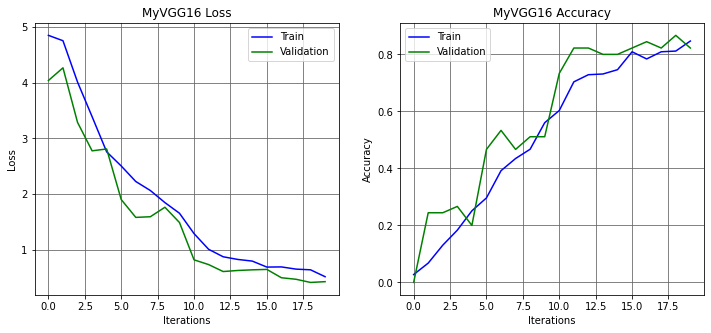

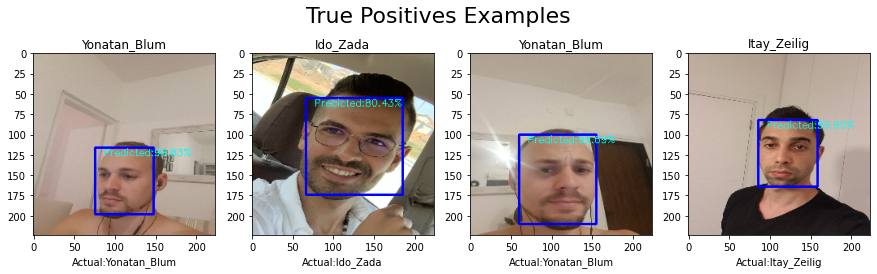

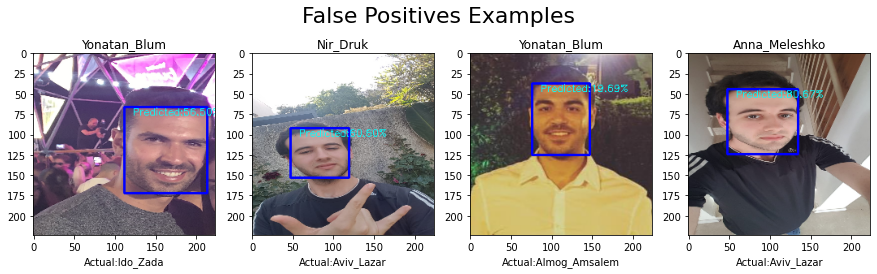

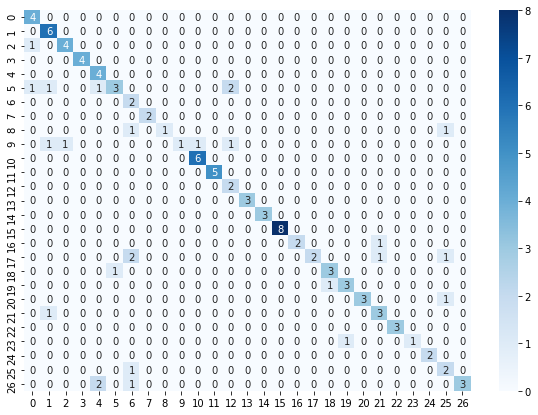

                 precision    recall  f1-score   support

    Zeev_Shavit       0.67      1.00      0.80         4
   Yonatan_Blum       0.67      1.00      0.80         6
  Yoav_Rytzfeld       0.80      0.80      0.80         5
  Ricky_Danipog       1.00      1.00      1.00         4
    Itay_Zeilig       0.57      1.00      0.73         4
       Ido_Zada       0.75      0.38      0.50         8
  Anna_Meleshko       0.29      1.00      0.44         2
 Aviv_Yampolsky       1.00      1.00      1.00         2
     Aviv_Lazar       1.00      0.33      0.50         3
  Almog_Amsalem       1.00      0.20      0.33         5
Majdi_Abu_Salah       0.86      1.00      0.92         6
 Hadar_Bonavida       1.00      1.00      1.00         5
  Chen_Zecharya       0.40      1.00      0.57         2
    Yigal_Diker       1.00      1.00      1.00         3
       Eden_Lev       1.00      1.00      1.00         3
  Daniel_Kornis       1.00      1.00      1.00         8
Daniel_Ivkovich       1.00    

In [0]:
plot_val_vs_train(train_losses, val_losses, train_acc, val_acc ,model_name='MyVGG16')
preds, targets, samples = get_predictions(model, test_loader)
show_examples(samples, 4)
show_scores(targets, preds)
torch.save(model.state_dict(),'/content/drive/My Drive/Colab Notebooks/CV/3 - Transfer Learning/MyVgg16.pt')


#My VGG16 Attempts Parameters

# First Attempt
With out Weights initialization
```
criterion = FocalLoss(alpha=0.25, gamma=4)
optim = Adam(vgg16.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optim, step_size=8, gamma=0.1)
```

## Accuracy of the network on the Test images: 56.757 %

---
## Second Attempt
With Weights initialization
```
criterion = FocalLoss(alpha=0.25, gamma=2)
optim = RAdam(vgg16.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
```
## Accuracy of the network on the Test images: 64.865 %
---

# Third attempt
With Weights initialization
```
vgg16 = VGG16(len(classes),dropout=0.4)
vgg16.apply(init_weights)
criterion = FocalLoss(alpha=0.25, gamma=2)
optim = RAdam(vgg16.parameters(), lr=1e-4, weight_decay=0)
scheduler = lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
```
## Accuracy of the network on the Test images: 65.766 %

# Best Attempt
With Weights initialization

```
criterion = nn.CrossEntropyLoss()
optim = RAdam(vgg16.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
```
# Accuracy of the network on the Test images: 76.577 %
![](https://drive.google.com/uc?export=view&id=1GfXjyDAv8E3pYYtY0JMsfRJS9d3355Af)

![](https://drive.google.com/uc?export=view&id=1ynC_AkeEWM1FDVOXHJTILQhKbhmmAOit)





# Transfer Learning
Selected Models:

*   resnet50
*   resnext50_32x4d
*   vgg16
*   googlenet
*   mobilenet_v2

those models can be freezed(no grad on the original model) and therefore we can fit only the last layer. So Tested those two approaches.
 
I chose the models randomly.
#### *Imported from torchvision.models
---



In [0]:
from torchvision.models import resnet50, resnext50_32x4d, googlenet, mobilenet_v2, densenet161

SAVE_PATH = '/content/drive/My Drive/Colab Notebooks/CV/3 - Transfer Learning/'

MODEL_PATHS = {'resnet50': SAVE_PATH + 'ResNet.pt',
               'resnext50': SAVE_PATH +'ResNext.pt',
               'densenet161': SAVE_PATH + 'DenseNet161.pt',
               'googlenet':  SAVE_PATH + 'GoogLeNet.pt',
               'mobilenet': SAVE_PATH + 'MobileNet.pt',
               'ensemble': SAVE_PATH + 'ensemble.pt'}

# Pretrained Resnet50

https://arxiv.org/abs/1512.03385

* in_featrues = 224x224x3
* (in_features of the last Linear layer) out_features = 2048

In [0]:
resnet = resnet50(pretrained=True) 
in_feat = resnet.fc.in_features
resnet.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_feat, len(classes))
            )

resnet.fc.apply(init_weights)

# freeze Pretrained model
# for param in resnet.parameters():
#     param.requires_grad_(False)

# criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()
optim = Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optim, step_size=6, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(resnet, criterion, optim, scheduler)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Epoch 1/20	Train loss: 3.17199	Train accuracy: 16.834	Validation loss: 1.94153 	 Validation accuracy: 51.111



Epoch 2/20	Train loss: 1.69140	Train accuracy: 56.533	Validation loss: 0.79613 	 Validation accuracy: 88.889



Epoch 3/20	Train loss: 1.00472	Train accuracy: 73.367	Validation loss: 0.31267 	 Validation accuracy: 91.111



Epoch 4/20	Train loss: 0.50600	Train accuracy: 87.940	Validation loss: 0.29174 	 Validation accuracy: 91.111



Epoch 5/20	Train loss: 0.29263	Train accuracy: 94.221	Validation loss: 0.13678 	 Validation accuracy: 95.556



Epoch 6/20	Train loss: 0.24998	Train accuracy: 94.221	Validation loss: 0.09091 	 Validation accuracy: 97.778



Epoch 7/20	Train loss: 0.14643	Train accuracy: 97.487	Validation loss: 0.08232 	 Validation accuracy: 97.778



Epoch 8/20	Train loss: 0.11568	Train accuracy: 99.246	Validation loss: 0.08503 	 Validation accuracy: 95.556



Epoch 9/20	Train loss: 0.13055	Train accuracy: 97.990	Validation loss: 0.10038 	 Validation accuracy: 95.556



Epoch 10/20	Train loss: 0.14846	Train accuracy: 97.739	Validation loss: 0.08147 	 Validation accuracy: 97.778



Epoch 11/20	Train loss: 0.12964	Train accuracy: 96.985	Validation loss: 0.08392 	 Validation accuracy: 95.556



Epoch 12/20	Train loss: 0.10088	Train accuracy: 97.990	Validation loss: 0.08343 	 Validation accuracy: 97.778



Epoch 13/20	Train loss: 0.09709	Train accuracy: 98.744	Validation loss: 0.07925 	 Validation accuracy: 97.778



Epoch 14/20	Train loss: 0.07569	Train accuracy: 98.995	Validation loss: 0.07525 	 Validation accuracy: 97.778



Epoch 15/20	Train loss: 0.11311	Train accuracy: 98.744	Validation loss: 0.08112 	 Validation accuracy: 97.778



Epoch 16/20	Train loss: 0.08831	Train accuracy: 98.995	Validation loss: 0.08729 	 Validation accuracy: 95.556



Epoch 17/20	Train loss: 0.12943	Train accuracy: 97.739	Validation loss: 0.08344 	 Validation accuracy: 97.778



Epoch 18/20	Train loss: 0.09664	Train accuracy: 99.497	Validation loss: 0.07964 	 Validation accuracy: 97.778



Epoch 19/20	Train loss: 0.09569	Train accuracy: 98.995	Validation loss: 0.07830 	 Validation accuracy: 97.778



Epoch 20/20	Train loss: 0.10526	Train accuracy: 98.744	Validation loss: 0.08662 	 Validation accuracy: 97.778


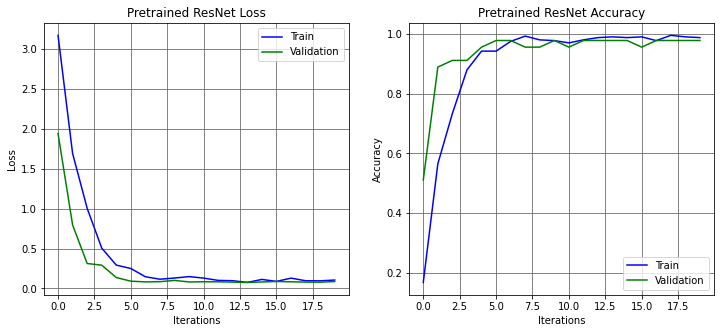

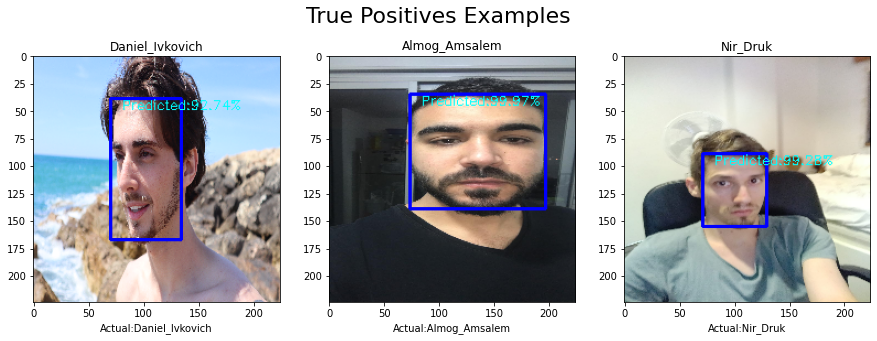

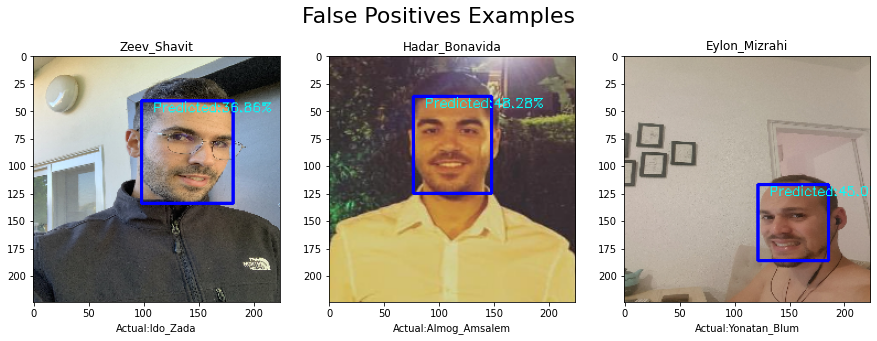

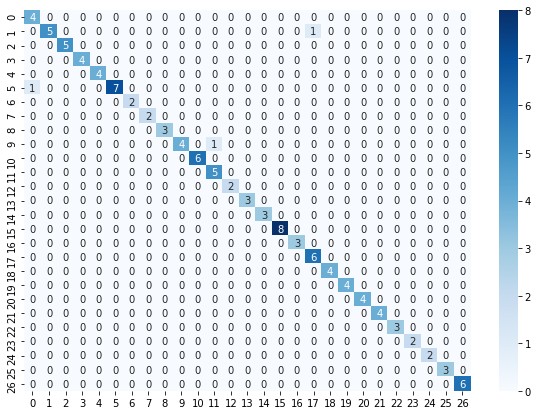

                 precision    recall  f1-score   support

    Zeev_Shavit       0.80      1.00      0.89         4
   Yonatan_Blum       1.00      0.83      0.91         6
  Yoav_Rytzfeld       1.00      1.00      1.00         5
  Ricky_Danipog       1.00      1.00      1.00         4
    Itay_Zeilig       1.00      1.00      1.00         4
       Ido_Zada       1.00      0.88      0.93         8
  Anna_Meleshko       1.00      1.00      1.00         2
 Aviv_Yampolsky       1.00      1.00      1.00         2
     Aviv_Lazar       1.00      1.00      1.00         3
  Almog_Amsalem       1.00      0.80      0.89         5
Majdi_Abu_Salah       1.00      1.00      1.00         6
 Hadar_Bonavida       0.83      1.00      0.91         5
  Chen_Zecharya       1.00      1.00      1.00         2
    Yigal_Diker       1.00      1.00      1.00         3
       Eden_Lev       1.00      1.00      1.00         3
  Daniel_Kornis       1.00      1.00      1.00         8
Daniel_Ivkovich       1.00    

In [0]:
plot_val_vs_train(train_losses, val_losses, train_acc, val_acc ,model_name='Pretrained ResNet')
preds, targets, samples = get_predictions(model, test_loader)
show_examples(samples, 3)
show_scores(targets, preds)

torch.save(model.state_dict(), MODEL_PATHS['resnet50'])

---

# Pretrained ResNext50
https://arxiv.org/abs/1611.05431
* in_featrues = 224x224x3
* (in_features of the last Linear layer) out_features = 2048

In [0]:
resnext = resnext50_32x4d(pretrained=True) # out_dim = 2048
in_feat = resnext.fc.in_features
resnext.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, len(classes))
            )

resnext.fc.apply(init_weights)
# for param in resnext.parameters():
#     param.requires_grad_(False)

# criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()
optim = Adam(resnext.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=6, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(resnext, criterion, optim, scheduler)



Epoch 1/20	Train loss: 2.81953	Train accuracy: 28.392	Validation loss: 1.18198 	 Validation accuracy: 77.778



Epoch 2/20	Train loss: 1.04394	Train accuracy: 75.628	Validation loss: 0.29413 	 Validation accuracy: 93.333



Epoch 3/20	Train loss: 0.41127	Train accuracy: 92.714	Validation loss: 0.15174 	 Validation accuracy: 95.556



Epoch 4/20	Train loss: 0.21524	Train accuracy: 95.980	Validation loss: 0.10177 	 Validation accuracy: 97.778



Epoch 5/20	Train loss: 0.12287	Train accuracy: 96.985	Validation loss: 0.10324 	 Validation accuracy: 97.778



Epoch 6/20	Train loss: 0.09476	Train accuracy: 98.241	Validation loss: 0.08614 	 Validation accuracy: 97.778



Epoch 7/20	Train loss: 0.06911	Train accuracy: 98.744	Validation loss: 0.08325 	 Validation accuracy: 97.778



Epoch 8/20	Train loss: 0.05586	Train accuracy: 98.995	Validation loss: 0.07918 	 Validation accuracy: 97.778



Epoch 9/20	Train loss: 0.08238	Train accuracy: 98.241	Validation loss: 0.08215 	 Validation accuracy: 97.778



Epoch 10/20	Train loss: 0.05456	Train accuracy: 99.246	Validation loss: 0.08274 	 Validation accuracy: 97.778



Epoch 11/20	Train loss: 0.07947	Train accuracy: 97.990	Validation loss: 0.07366 	 Validation accuracy: 97.778



Epoch 12/20	Train loss: 0.05180	Train accuracy: 99.497	Validation loss: 0.07283 	 Validation accuracy: 97.778



Epoch 13/20	Train loss: 0.04086	Train accuracy: 99.497	Validation loss: 0.07370 	 Validation accuracy: 97.778



Epoch 14/20	Train loss: 0.03271	Train accuracy: 99.749	Validation loss: 0.07582 	 Validation accuracy: 97.778



Epoch 15/20	Train loss: 0.03574	Train accuracy: 99.749	Validation loss: 0.07014 	 Validation accuracy: 97.778



Epoch 16/20	Train loss: 0.04621	Train accuracy: 99.497	Validation loss: 0.07848 	 Validation accuracy: 97.778



Epoch 17/20	Train loss: 0.04609	Train accuracy: 99.246	Validation loss: 0.06165 	 Validation accuracy: 97.778



Epoch 18/20	Train loss: 0.05554	Train accuracy: 98.995	Validation loss: 0.07936 	 Validation accuracy: 97.778



Epoch 19/20	Train loss: 0.05607	Train accuracy: 99.246	Validation loss: 0.07718 	 Validation accuracy: 97.778



Epoch 20/20	Train loss: 0.04051	Train accuracy: 99.246	Validation loss: 0.07566 	 Validation accuracy: 97.778


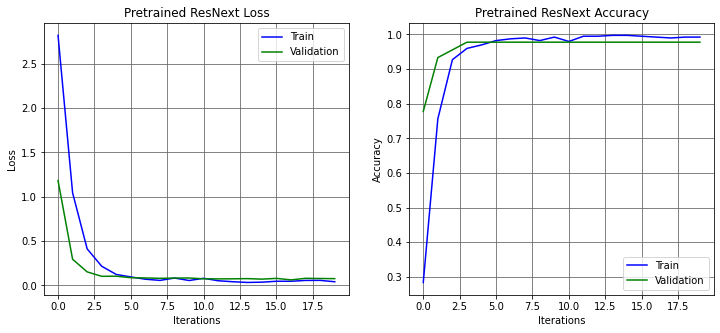

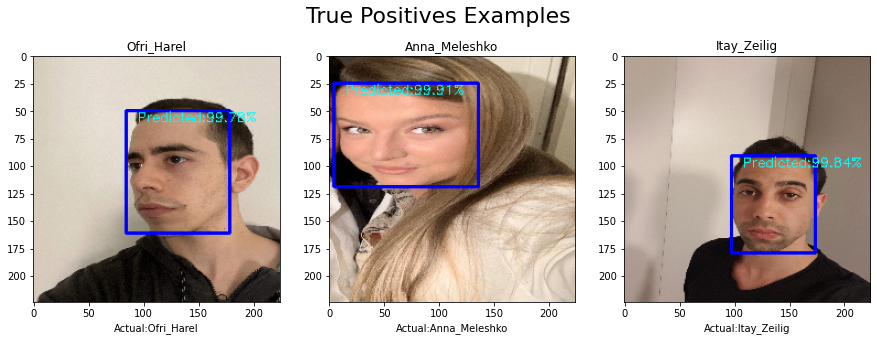

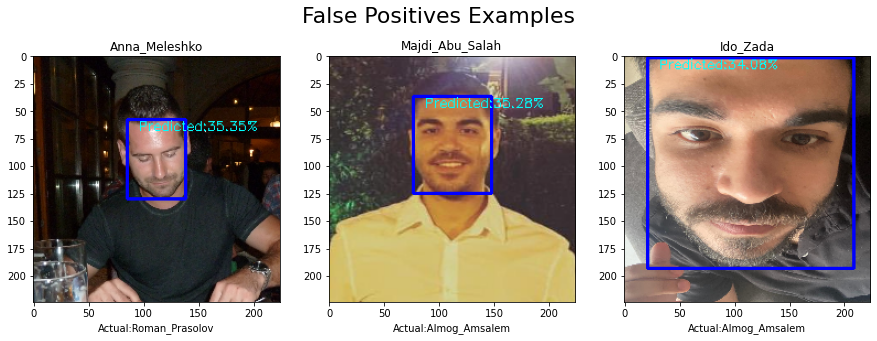

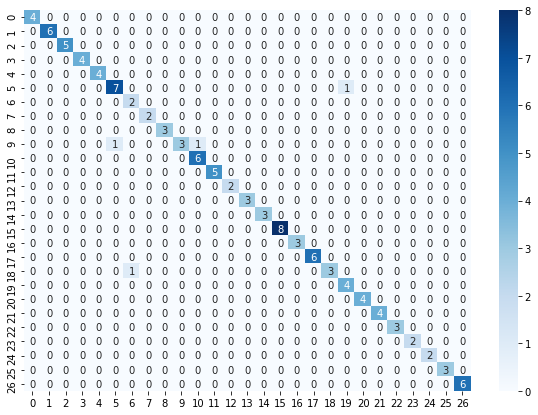

                 precision    recall  f1-score   support

    Zeev_Shavit       1.00      1.00      1.00         4
   Yonatan_Blum       1.00      1.00      1.00         6
  Yoav_Rytzfeld       1.00      1.00      1.00         5
  Ricky_Danipog       1.00      1.00      1.00         4
    Itay_Zeilig       1.00      1.00      1.00         4
       Ido_Zada       0.88      0.88      0.88         8
  Anna_Meleshko       0.67      1.00      0.80         2
 Aviv_Yampolsky       1.00      1.00      1.00         2
     Aviv_Lazar       1.00      1.00      1.00         3
  Almog_Amsalem       1.00      0.60      0.75         5
Majdi_Abu_Salah       0.86      1.00      0.92         6
 Hadar_Bonavida       1.00      1.00      1.00         5
  Chen_Zecharya       1.00      1.00      1.00         2
    Yigal_Diker       1.00      1.00      1.00         3
       Eden_Lev       1.00      1.00      1.00         3
  Daniel_Kornis       1.00      1.00      1.00         8
Daniel_Ivkovich       1.00    

In [0]:
plot_val_vs_train(train_losses, val_losses, train_acc, val_acc ,model_name='Pretrained ResNext')
preds, targets, samples = get_predictions(model, test_loader)
show_examples(samples, 3)
show_scores(targets, preds)

torch.save(model.state_dict(), MODEL_PATHS['resnext50'])

---

# Pretrained GoogLeNet
https://arxiv.org/abs/1409.4842

* in_featrues = 224x224x3
* (in_features of the last Linear layer) out_features = 1024


In [0]:
googleNet = googlenet(pretrained=True)
in_feat = googleNet.fc.in_features
googleNet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, len(classes))
            )

googleNet.fc.apply(init_weights)

# for param in googleNet.parameters():
#     param.requires_grad_(False)

# criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()
optim = Adam(googleNet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optim, step_size=8, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(googleNet, criterion, optim, scheduler,epochs=20)


Epoch 1/20	Train loss: 2.70613	Train accuracy: 28.643	Validation loss: 1.65603 	 Validation accuracy: 53.333



Epoch 2/20	Train loss: 1.26708	Train accuracy: 64.322	Validation loss: 0.99799 	 Validation accuracy: 75.556



Epoch 3/20	Train loss: 0.71646	Train accuracy: 81.658	Validation loss: 0.50503 	 Validation accuracy: 80.000



Epoch 4/20	Train loss: 0.39626	Train accuracy: 89.698	Validation loss: 0.39333 	 Validation accuracy: 84.444



Epoch 5/20	Train loss: 0.34267	Train accuracy: 89.447	Validation loss: 0.36788 	 Validation accuracy: 86.667



Epoch 6/20	Train loss: 0.34528	Train accuracy: 89.196	Validation loss: 0.24401 	 Validation accuracy: 95.556



Epoch 7/20	Train loss: 0.28450	Train accuracy: 93.216	Validation loss: 0.15193 	 Validation accuracy: 93.333



Epoch 8/20	Train loss: 0.23522	Train accuracy: 92.714	Validation loss: 0.13402 	 Validation accuracy: 95.556



Epoch 9/20	Train loss: 0.14218	Train accuracy: 96.734	Validation loss: 0.06082 	 Validation accuracy: 97.778



Epoch 10/20	Train loss: 0.10221	Train accuracy: 97.990	Validation loss: 0.05995 	 Validation accuracy: 97.778



Epoch 11/20	Train loss: 0.05582	Train accuracy: 99.246	Validation loss: 0.03911 	 Validation accuracy: 100.000



Epoch 12/20	Train loss: 0.04158	Train accuracy: 99.246	Validation loss: 0.03225 	 Validation accuracy: 100.000



Epoch 13/20	Train loss: 0.06482	Train accuracy: 98.744	Validation loss: 0.02900 	 Validation accuracy: 100.000



Epoch 14/20	Train loss: 0.04647	Train accuracy: 98.995	Validation loss: 0.02227 	 Validation accuracy: 100.000



Epoch 15/20	Train loss: 0.02337	Train accuracy: 99.749	Validation loss: 0.02365 	 Validation accuracy: 100.000



Epoch 16/20	Train loss: 0.02589	Train accuracy: 99.749	Validation loss: 0.02833 	 Validation accuracy: 100.000



Epoch 17/20	Train loss: 0.04335	Train accuracy: 99.497	Validation loss: 0.02568 	 Validation accuracy: 100.000



Epoch 18/20	Train loss: 0.02923	Train accuracy: 99.497	Validation loss: 0.02664 	 Validation accuracy: 100.000



Epoch 19/20	Train loss: 0.02438	Train accuracy: 99.749	Validation loss: 0.02775 	 Validation accuracy: 100.000



Epoch 20/20	Train loss: 0.02788	Train accuracy: 100.000	Validation loss: 0.02773 	 Validation accuracy: 100.000


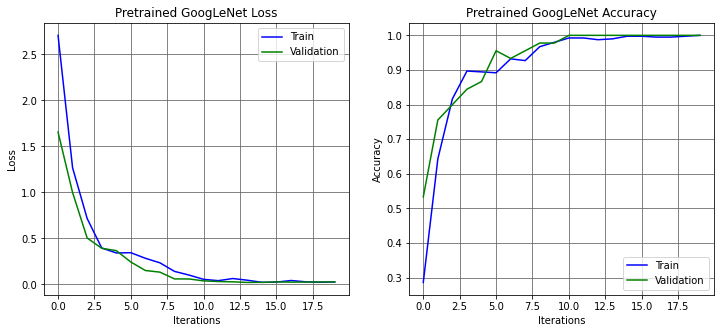

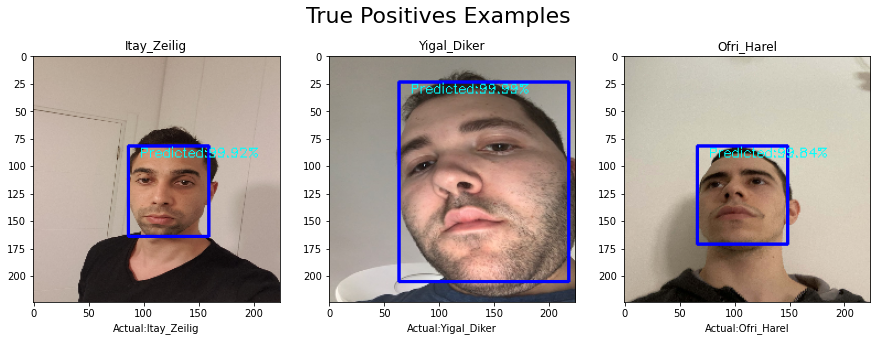

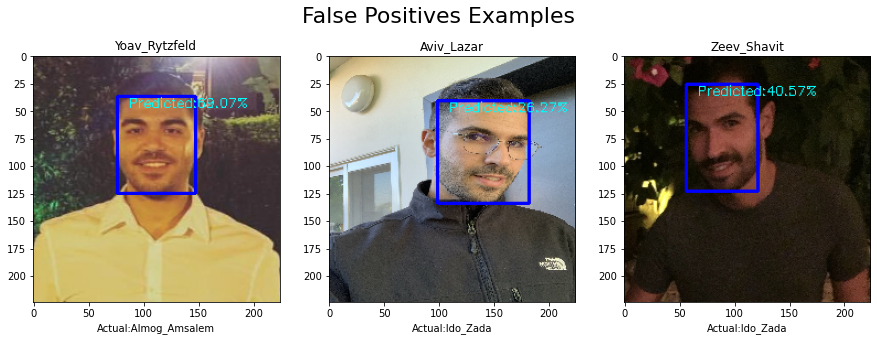

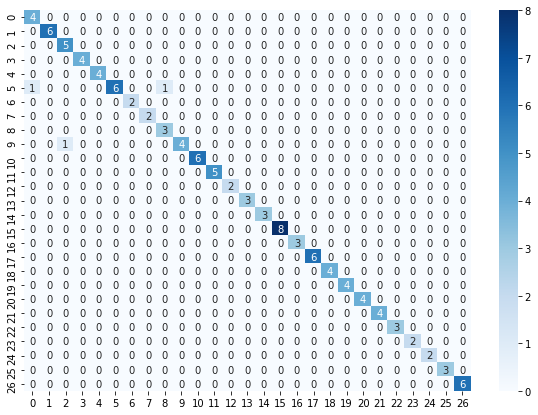

                 precision    recall  f1-score   support

    Zeev_Shavit       0.80      1.00      0.89         4
   Yonatan_Blum       1.00      1.00      1.00         6
  Yoav_Rytzfeld       0.83      1.00      0.91         5
  Ricky_Danipog       1.00      1.00      1.00         4
    Itay_Zeilig       1.00      1.00      1.00         4
       Ido_Zada       1.00      0.75      0.86         8
  Anna_Meleshko       1.00      1.00      1.00         2
 Aviv_Yampolsky       1.00      1.00      1.00         2
     Aviv_Lazar       0.75      1.00      0.86         3
  Almog_Amsalem       1.00      0.80      0.89         5
Majdi_Abu_Salah       1.00      1.00      1.00         6
 Hadar_Bonavida       1.00      1.00      1.00         5
  Chen_Zecharya       1.00      1.00      1.00         2
    Yigal_Diker       1.00      1.00      1.00         3
       Eden_Lev       1.00      1.00      1.00         3
  Daniel_Kornis       1.00      1.00      1.00         8
Daniel_Ivkovich       1.00    

In [0]:
plot_val_vs_train(train_losses, val_losses, train_acc, val_acc ,model_name='Pretrained GoogLeNet')
preds, targets, samples = get_predictions(model, test_loader)
show_examples(samples, 3)
show_scores(targets, preds)
torch.save(model.state_dict(),MODEL_PATHS['googlenet'])

---

# Pretrained DenseNet

https://arxiv.org/abs/1608.06993

* in_featrues = 224x224x3
* (in_features of the last Linear layer) out_features = 2028


In [0]:
densenet = densenet161(pretrained=True)
in_feat = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_feat, len(classes))
            )
densenet.classifier .apply(init_weights)

# for param in densenet.parameters():
#     param.requires_grad_(False)

criterion = nn.CrossEntropyLoss()

optim = Adam(densenet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optim, step_size=6, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(densenet, criterion, optim, scheduler)


Epoch 1/20	Train loss: 2.99031	Train accuracy: 21.357	Validation loss: 4.46288 	 Validation accuracy: 11.111



Epoch 2/20	Train loss: 1.81411	Train accuracy: 48.241	Validation loss: 2.93906 	 Validation accuracy: 28.889



Epoch 3/20	Train loss: 1.30074	Train accuracy: 60.302	Validation loss: 2.54960 	 Validation accuracy: 40.000



Epoch 4/20	Train loss: 0.98504	Train accuracy: 71.357	Validation loss: 2.59889 	 Validation accuracy: 37.778



Epoch 5/20	Train loss: 0.60028	Train accuracy: 81.658	Validation loss: 0.29951 	 Validation accuracy: 95.556



Epoch 6/20	Train loss: 0.44254	Train accuracy: 88.191	Validation loss: 0.19276 	 Validation accuracy: 97.778



Epoch 7/20	Train loss: 0.21867	Train accuracy: 93.719	Validation loss: 0.06124 	 Validation accuracy: 97.778



Epoch 8/20	Train loss: 0.13072	Train accuracy: 97.739	Validation loss: 0.05012 	 Validation accuracy: 100.000



Epoch 9/20	Train loss: 0.09169	Train accuracy: 98.995	Validation loss: 0.03604 	 Validation accuracy: 100.000



Epoch 10/20	Train loss: 0.08546	Train accuracy: 98.744	Validation loss: 0.02453 	 Validation accuracy: 100.000



Epoch 11/20	Train loss: 0.05985	Train accuracy: 98.995	Validation loss: 0.02247 	 Validation accuracy: 100.000



Epoch 12/20	Train loss: 0.05447	Train accuracy: 99.497	Validation loss: 0.03133 	 Validation accuracy: 100.000



Epoch 13/20	Train loss: 0.05092	Train accuracy: 99.246	Validation loss: 0.02588 	 Validation accuracy: 100.000



Epoch 14/20	Train loss: 0.04850	Train accuracy: 99.749	Validation loss: 0.02144 	 Validation accuracy: 100.000



Epoch 15/20	Train loss: 0.05484	Train accuracy: 99.749	Validation loss: 0.02278 	 Validation accuracy: 100.000



Epoch 16/20	Train loss: 0.05018	Train accuracy: 99.246	Validation loss: 0.02210 	 Validation accuracy: 100.000



Epoch 17/20	Train loss: 0.05323	Train accuracy: 99.497	Validation loss: 0.02263 	 Validation accuracy: 100.000



Epoch 18/20	Train loss: 0.04905	Train accuracy: 99.749	Validation loss: 0.02120 	 Validation accuracy: 100.000



Epoch 19/20	Train loss: 0.05865	Train accuracy: 98.995	Validation loss: 0.02481 	 Validation accuracy: 100.000



Epoch 20/20	Train loss: 0.04442	Train accuracy: 99.246	Validation loss: 0.02240 	 Validation accuracy: 100.000


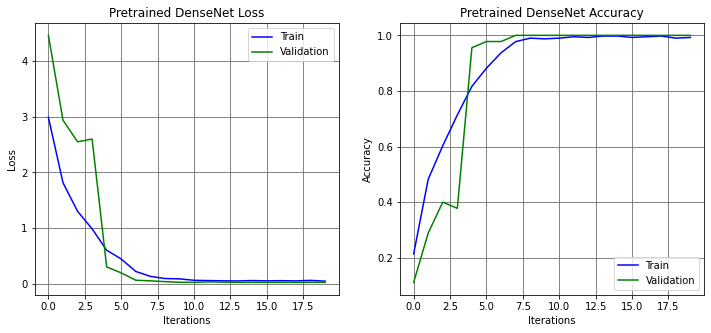

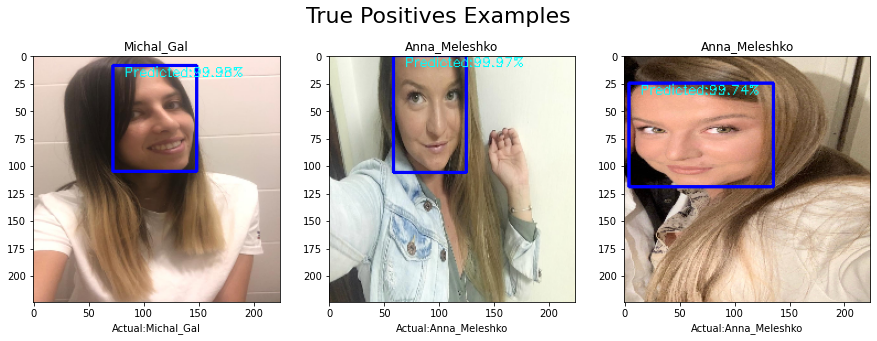

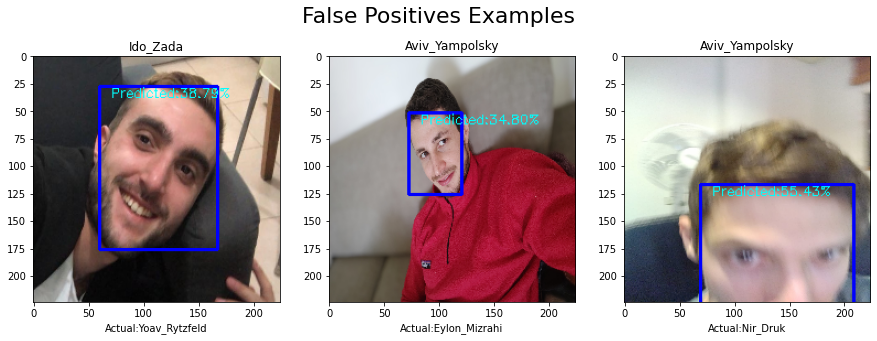

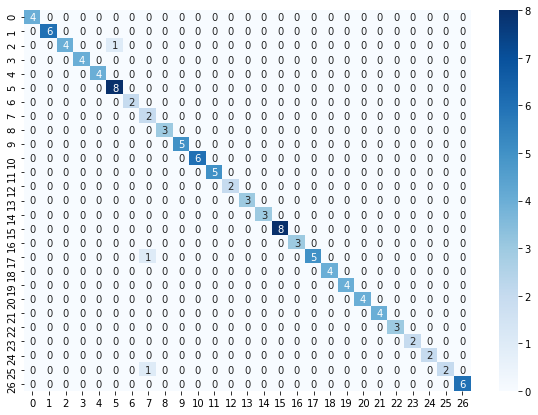

                 precision    recall  f1-score   support

    Zeev_Shavit       1.00      1.00      1.00         4
   Yonatan_Blum       1.00      1.00      1.00         6
  Yoav_Rytzfeld       1.00      0.80      0.89         5
  Ricky_Danipog       1.00      1.00      1.00         4
    Itay_Zeilig       1.00      1.00      1.00         4
       Ido_Zada       0.89      1.00      0.94         8
  Anna_Meleshko       1.00      1.00      1.00         2
 Aviv_Yampolsky       0.50      1.00      0.67         2
     Aviv_Lazar       1.00      1.00      1.00         3
  Almog_Amsalem       1.00      1.00      1.00         5
Majdi_Abu_Salah       1.00      1.00      1.00         6
 Hadar_Bonavida       1.00      1.00      1.00         5
  Chen_Zecharya       1.00      1.00      1.00         2
    Yigal_Diker       1.00      1.00      1.00         3
       Eden_Lev       1.00      1.00      1.00         3
  Daniel_Kornis       1.00      1.00      1.00         8
Daniel_Ivkovich       1.00    

In [0]:
plot_val_vs_train(train_losses, val_losses, train_acc, val_acc ,model_name='Pretrained DenseNet')
preds, targets, samples = get_predictions(model, test_loader)
show_examples(samples, 3)
show_scores(targets, preds)
torch.save(model.state_dict(),MODEL_PATHS['densenet161'])

---

# Pretrained MobileNet

https://arxiv.org/abs/1704.04861


* in_featrues = 224x224x3
* (in_features of the last Linear layer) out_features = 1280

In [0]:
mobilenet = mobilenet_v2(pretrained=True)
in_feat = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_feat, len(classes))
            )

mobilenet.classifier.apply(init_weights)

# for param in resnext.parameters():
#     param.requires_grad_(False)

criterion = nn.CrossEntropyLoss()
optim = RAdam(mobilenet.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=8, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(mobilenet, criterion, optim, scheduler)


Epoch 1/20	Train loss: 3.42769	Train accuracy: 7.789	Validation loss: 2.51676 	 Validation accuracy: 28.889



Epoch 2/20	Train loss: 2.24624	Train accuracy: 42.714	Validation loss: 1.21586 	 Validation accuracy: 73.333



Epoch 3/20	Train loss: 1.21918	Train accuracy: 71.106	Validation loss: 0.49033 	 Validation accuracy: 91.111



Epoch 4/20	Train loss: 0.72760	Train accuracy: 83.920	Validation loss: 0.33275 	 Validation accuracy: 93.333



Epoch 5/20	Train loss: 0.38961	Train accuracy: 91.206	Validation loss: 0.21187 	 Validation accuracy: 95.556



Epoch 6/20	Train loss: 0.25144	Train accuracy: 94.724	Validation loss: 0.13933 	 Validation accuracy: 95.556



Epoch 7/20	Train loss: 0.19789	Train accuracy: 96.734	Validation loss: 0.12277 	 Validation accuracy: 95.556



Epoch 8/20	Train loss: 0.15930	Train accuracy: 96.734	Validation loss: 0.08450 	 Validation accuracy: 97.778



Epoch 9/20	Train loss: 0.13260	Train accuracy: 96.482	Validation loss: 0.07009 	 Validation accuracy: 97.778



Epoch 10/20	Train loss: 0.08436	Train accuracy: 98.995	Validation loss: 0.05925 	 Validation accuracy: 97.778



Epoch 11/20	Train loss: 0.09127	Train accuracy: 98.995	Validation loss: 0.04873 	 Validation accuracy: 100.000



Epoch 12/20	Train loss: 0.07578	Train accuracy: 98.492	Validation loss: 0.05089 	 Validation accuracy: 100.000



Epoch 13/20	Train loss: 0.06953	Train accuracy: 99.246	Validation loss: 0.05277 	 Validation accuracy: 97.778



Epoch 14/20	Train loss: 0.06801	Train accuracy: 98.744	Validation loss: 0.05609 	 Validation accuracy: 100.000



Epoch 15/20	Train loss: 0.06160	Train accuracy: 99.246	Validation loss: 0.05409 	 Validation accuracy: 100.000



Epoch 16/20	Train loss: 0.05510	Train accuracy: 99.246	Validation loss: 0.05114 	 Validation accuracy: 100.000



Epoch 17/20	Train loss: 0.04180	Train accuracy: 99.749	Validation loss: 0.04455 	 Validation accuracy: 100.000



Epoch 18/20	Train loss: 0.04853	Train accuracy: 100.000	Validation loss: 0.05419 	 Validation accuracy: 97.778



Epoch 19/20	Train loss: 0.04118	Train accuracy: 99.497	Validation loss: 0.05115 	 Validation accuracy: 100.000



Epoch 20/20	Train loss: 0.05415	Train accuracy: 99.497	Validation loss: 0.05145 	 Validation accuracy: 100.000


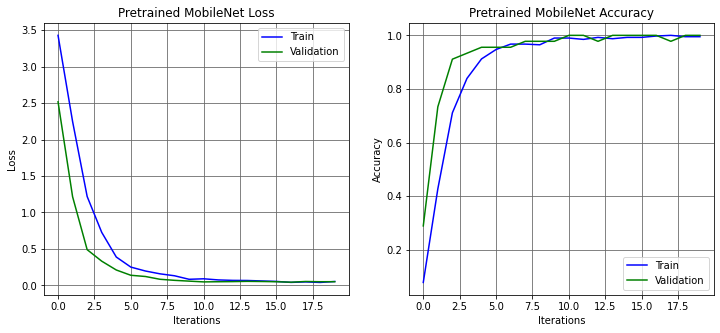

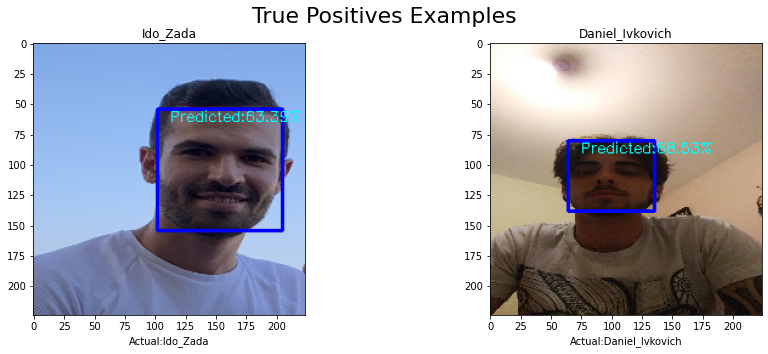

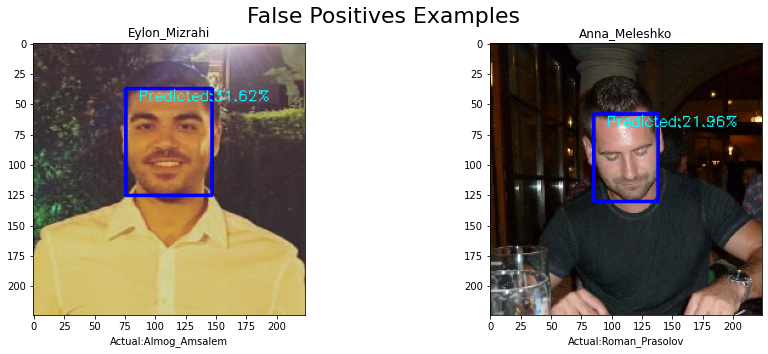

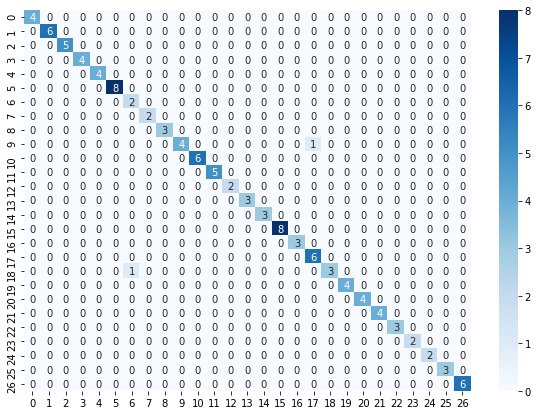

                 precision    recall  f1-score   support

    Zeev_Shavit       1.00      1.00      1.00         4
   Yonatan_Blum       1.00      1.00      1.00         6
  Yoav_Rytzfeld       1.00      1.00      1.00         5
  Ricky_Danipog       1.00      1.00      1.00         4
    Itay_Zeilig       1.00      1.00      1.00         4
       Ido_Zada       1.00      1.00      1.00         8
  Anna_Meleshko       0.67      1.00      0.80         2
 Aviv_Yampolsky       1.00      1.00      1.00         2
     Aviv_Lazar       1.00      1.00      1.00         3
  Almog_Amsalem       1.00      0.80      0.89         5
Majdi_Abu_Salah       1.00      1.00      1.00         6
 Hadar_Bonavida       1.00      1.00      1.00         5
  Chen_Zecharya       1.00      1.00      1.00         2
    Yigal_Diker       1.00      1.00      1.00         3
       Eden_Lev       1.00      1.00      1.00         3
  Daniel_Kornis       1.00      1.00      1.00         8
Daniel_Ivkovich       1.00    

In [0]:
plot_val_vs_train(train_losses, val_losses, train_acc, val_acc ,model_name='Pretrained MobileNet')
preds, targets, samples = get_predictions(model, test_loader)
show_examples(samples, 2)
show_scores(targets, preds)

torch.save(model.state_dict(),MODEL_PATHS['mobilenet'])

In [0]:

class MyEnsemble(nn.Module):

    ###################################
    ## DIMS OF THE LAST LINEAR LAYER ##
    ###################################
    ## in_dim = 224x224x3
    # googlenet       out_dim = 1024
    # resnet50        out_dim = 2048
    # resnext50_32x4d out_dim = 2048
    # densenet161     out_dim = 2208
    # mobilenet_v2    out_dim = 1280

    def __init__(self, num_classes, freeze = True, dropout=0.5):
        super(MyEnsemble,self).__init__()
        self.freeze = freeze
        
        self.googleNet = googlenet(pretrained=True)
        self.googleNet.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024, len(classes))
            )
        self.googleNet.load_state_dict(torch.load(MODEL_PATHS['googlenet']))

        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, num_classes)
            ) 
        self.resnet.load_state_dict(torch.load(MODEL_PATHS['resnet50']))

        self.resnext = resnext50_32x4d(pretrained=True) 
        self.resnext.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, num_classes)
            )
        self.resnext.load_state_dict(torch.load(MODEL_PATHS['resnext50']))

        self.densenet = densenet161(pretrained=True)
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2208, num_classes)
            )
        self.densenet.load_state_dict(torch.load(MODEL_PATHS['densenet161']))
        

        self.mobilenet = mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
            )
        self.mobilenet.load_state_dict(torch.load(MODEL_PATHS['mobilenet']))
        
        # Enable/Disable grads [Freeze the model] 
        self.freeze_model(self.googleNet) 
        self.freeze_model(self.resnet) 
        self.freeze_model(self.resnext) 
        self.freeze_model(self.densenet) 
        self.freeze_model(self.mobilenet) 

        #Remove the Last layer
        self.googleNet.fc   = nn.Identity() 
        self.resnet.fc         = nn.Identity() 
        self.resnext.fc        = nn.Identity() 

        self.densenet.classifier   = nn.Identity()
        self.mobilenet.classifier  = nn.Identity()

        # Last Linear Layer: in_features=Sum of all out features of the models
        self.last_linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024+2048+2048+2208+1280, num_classes)
            )
        

    def freeze_model(self, model):
        for param in model.parameters():
            param.requires_grad_(not self.freeze)

    def forward(self, x):
        # clone to make sure x is not changed by inplace methods
        x = x.clone() 

        # passing the input on each model
        x1 = self.googleNet(x)  
        x2 = self.resnet(x) 
        x3 = self.resnext(x)  
        x4 = self.densenet(x) 
        x5 = self.mobilenet(x)

        # append all outputs 
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = self.last_linear(F.relu(x))

        return x





In [0]:
model = MyEnsemble(len(classes), freeze = True, dropout=0.3)
model.last_linear.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optim = RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=8, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(model, criterion, optim, scheduler)



Epoch 1/20	Train loss: 3.22191	Train accuracy: 13.819	Validation loss: 2.43948 	 Validation accuracy: 46.667



Epoch 2/20	Train loss: 1.60631	Train accuracy: 66.583	Validation loss: 0.69169 	 Validation accuracy: 100.000



Epoch 3/20	Train loss: 0.58963	Train accuracy: 94.472	Validation loss: 0.20581 	 Validation accuracy: 100.000



Epoch 4/20	Train loss: 0.21718	Train accuracy: 98.995	Validation loss: 0.10124 	 Validation accuracy: 100.000



Epoch 5/20	Train loss: 0.12994	Train accuracy: 99.246	Validation loss: 0.06861 	 Validation accuracy: 100.000



Epoch 6/20	Train loss: 0.09766	Train accuracy: 99.246	Validation loss: 0.04833 	 Validation accuracy: 100.000



Epoch 7/20	Train loss: 0.06504	Train accuracy: 100.000	Validation loss: 0.04441 	 Validation accuracy: 100.000



Epoch 8/20	Train loss: 0.05096	Train accuracy: 100.000	Validation loss: 0.04005 	 Validation accuracy: 100.000



Epoch 9/20	Train loss: 0.04726	Train accuracy: 99.749	Validation loss: 0.03692 	 Validation accuracy: 100.000



Epoch 10/20	Train loss: 0.04996	Train accuracy: 99.749	Validation loss: 0.03611 	 Validation accuracy: 100.000



Epoch 11/20	Train loss: 0.05067	Train accuracy: 100.000	Validation loss: 0.03049 	 Validation accuracy: 100.000



Epoch 12/20	Train loss: 0.03503	Train accuracy: 100.000	Validation loss: 0.03375 	 Validation accuracy: 100.000



Epoch 13/20	Train loss: 0.05690	Train accuracy: 98.995	Validation loss: 0.03180 	 Validation accuracy: 100.000



Epoch 14/20	Train loss: 0.03948	Train accuracy: 99.749	Validation loss: 0.02643 	 Validation accuracy: 100.000



Epoch 15/20	Train loss: 0.04534	Train accuracy: 100.000	Validation loss: 0.02444 	 Validation accuracy: 100.000



Epoch 16/20	Train loss: 0.03221	Train accuracy: 100.000	Validation loss: 0.02802 	 Validation accuracy: 100.000



Epoch 17/20	Train loss: 0.04113	Train accuracy: 99.749	Validation loss: 0.02536 	 Validation accuracy: 100.000



Epoch 18/20	Train loss: 0.03207	Train accuracy: 99.749	Validation loss: 0.02495 	 Validation accuracy: 100.000



Epoch 19/20	Train loss: 0.03397	Train accuracy: 100.000	Validation loss: 0.02365 	 Validation accuracy: 100.000



Epoch 20/20	Train loss: 0.03989	Train accuracy: 99.749	Validation loss: 0.02292 	 Validation accuracy: 100.000


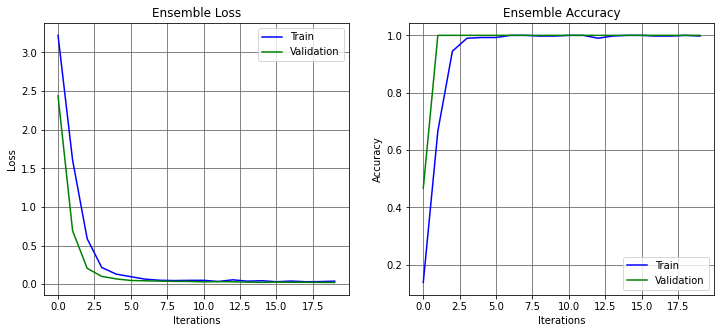

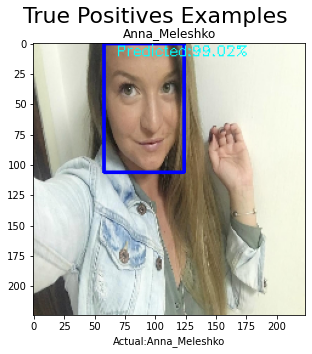

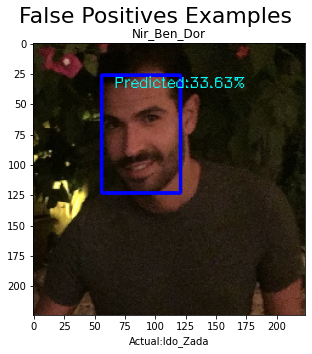

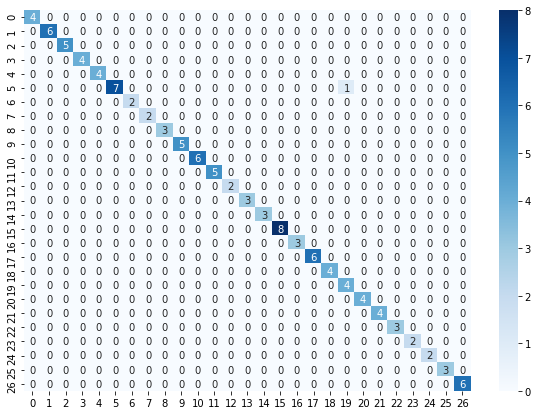

                 precision    recall  f1-score   support

    Zeev_Shavit       1.00      1.00      1.00         4
   Yonatan_Blum       1.00      1.00      1.00         6
  Yoav_Rytzfeld       1.00      1.00      1.00         5
  Ricky_Danipog       1.00      1.00      1.00         4
    Itay_Zeilig       1.00      1.00      1.00         4
       Ido_Zada       1.00      0.88      0.93         8
  Anna_Meleshko       1.00      1.00      1.00         2
 Aviv_Yampolsky       1.00      1.00      1.00         2
     Aviv_Lazar       1.00      1.00      1.00         3
  Almog_Amsalem       1.00      1.00      1.00         5
Majdi_Abu_Salah       1.00      1.00      1.00         6
 Hadar_Bonavida       1.00      1.00      1.00         5
  Chen_Zecharya       1.00      1.00      1.00         2
    Yigal_Diker       1.00      1.00      1.00         3
       Eden_Lev       1.00      1.00      1.00         3
  Daniel_Kornis       1.00      1.00      1.00         8
Daniel_Ivkovich       1.00    

In [0]:
plot_val_vs_train(train_losses, val_losses, train_acc, val_acc ,model_name='Ensemble')
preds, targets, samples = get_predictions(model, test_loader)
show_examples(samples, 1)
show_scores(targets, preds)
torch.save(model.state_dict(),MODEL_PATHS['ensemble'])

In [20]:
model = MyEnsemble(len(classes), freeze = True, dropout=0.3)
model.last_linear.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optim = RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=6, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc = fit_model(model, criterion, optim, scheduler)



Epoch 1/20	Train loss: 3.23685	Train accuracy: 11.055	Validation loss: 2.16308 	 Validation accuracy: 62.222



Epoch 2/20	Train loss: 1.66488	Train accuracy: 64.322	Validation loss: 0.62208 	 Validation accuracy: 97.778



Epoch 3/20	Train loss: 0.59968	Train accuracy: 95.477	Validation loss: 0.20126 	 Validation accuracy: 97.778



Epoch 4/20	Train loss: 0.26790	Train accuracy: 97.739	Validation loss: 0.10852 	 Validation accuracy: 97.778



Epoch 5/20	Train loss: 0.14576	Train accuracy: 99.246	Validation loss: 0.05783 	 Validation accuracy: 100.000



Epoch 6/20	Train loss: 0.08760	Train accuracy: 99.749	Validation loss: 0.06509 	 Validation accuracy: 97.778



Epoch 7/20	Train loss: 0.07650	Train accuracy: 99.749	Validation loss: 0.06117 	 Validation accuracy: 97.778



Epoch 8/20	Train loss: 0.07423	Train accuracy: 99.749	Validation loss: 0.05691 	 Validation accuracy: 97.778



Epoch 9/20	Train loss: 0.07736	Train accuracy: 99.749	Validation loss: 0.05683 	 Validation accuracy: 97.778



Epoch 10/20	Train loss: 0.07780	Train accuracy: 99.497	Validation loss: 0.05584 	 Validation accuracy: 97.778



Epoch 11/20	Train loss: 0.07503	Train accuracy: 99.497	Validation loss: 0.04846 	 Validation accuracy: 97.778



Epoch 12/20	Train loss: 0.05458	Train accuracy: 99.749	Validation loss: 0.05615 	 Validation accuracy: 97.778



Epoch 13/20	Train loss: 0.05452	Train accuracy: 100.000	Validation loss: 0.05109 	 Validation accuracy: 97.778



Epoch 14/20	Train loss: 0.06382	Train accuracy: 99.749	Validation loss: 0.04779 	 Validation accuracy: 97.778



Epoch 15/20	Train loss: 0.07901	Train accuracy: 99.749	Validation loss: 0.04511 	 Validation accuracy: 100.000



Epoch 16/20	Train loss: 0.04925	Train accuracy: 100.000	Validation loss: 0.04698 	 Validation accuracy: 100.000



Epoch 17/20	Train loss: 0.05896	Train accuracy: 99.497	Validation loss: 0.04648 	 Validation accuracy: 97.778



Epoch 18/20	Train loss: 0.05480	Train accuracy: 99.749	Validation loss: 0.04514 	 Validation accuracy: 97.778



Epoch 19/20	Train loss: 0.05811	Train accuracy: 99.749	Validation loss: 0.04548 	 Validation accuracy: 97.778



Epoch 20/20	Train loss: 0.06126	Train accuracy: 99.497	Validation loss: 0.04649 	 Validation accuracy: 97.778


# Summary
On this assignment I used some of the methods stated on lecture 8 on how to choose the hyper-parameters.
I learned how to choose the learnning rate and to tune it with LR schduler. The process of choosing the right hyper parameters took some time as I needed to follow after the model training output to decide if the parameters needed to be changed or tuned.

On the begining of the training phase a chose the parameters randomly some were good and some were bad. The results of the process are stated above.

For the ensemble I chose to "freeze" the loaded models because they had good results on the training phase individualy and the results were excellent. I tried to train the ensemble without freezing the models and the training process were too long and the results were mediocre. 



# Some Samples downloaded from Facebook with The ensemble model

In [70]:

def predict(mdoel, image):
    detection = face_detector.get_face_ROI(image)
    (startX, startY, endX, endY) = detection
    face = image[startY:endY, startX:endX]
    face = cv2.resize(face, (224,224),cv2.INTER_AREA)

    face = tv.transforms.ToTensor()(face)
    #normalize to fit imagenet normalization
    face = tv.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(face)

    outputs = F.softmax(model(face[np.newaxis,:,:,:]),dim=1)
    prob, predicted = torch.max(outputs.data, 1)
    text = "Predicted:{:.2f}%".format(prob.item() * 100)
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(image, text, (startX+10, startY+10),cv2.FONT_ITALIC, 0.4, (255, 0, 0), 1)
    plt.title(classes[predicted])
    plt.imshow(image);

model = MyEnsemble(num_classes = len(classes))
model.load_state_dict(torch.load(MODEL_PATHS['ensemble']))



<All keys matched successfully>

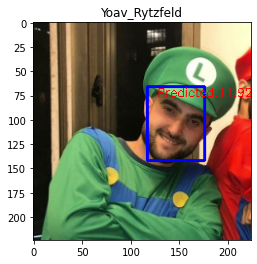

In [78]:
img = cv2.imread('yoavMario.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(224,224),cv2.INTER_AREA)

predict(model2,img)

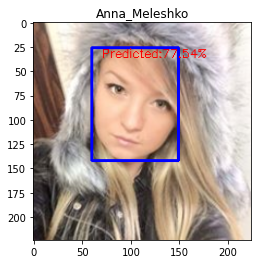

In [29]:
img = cv2.imread('anna.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(224,224),cv2.INTER_AREA)
predict(model,img)